## Install required packages

In [1]:
# !pip install torch torchvision huggingface_hub opencv-python matplotlib

## Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import zipfile
from huggingface_hub import hf_hub_download
import glob

## Download model arch

In [3]:
!wget https://raw.githubusercontent.com/evan6007/FPGA-LPR/main/model_utils.py

--2025-05-06 05:02:42--  https://raw.githubusercontent.com/evan6007/FPGA-LPR/main/model_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10390 (10K) [text/plain]
Saving to: ‘model_utils.py’

model_utils.py      100%[===================>]  10.15K  --.-KB/s    in 0s      

2025-05-06 05:02:42 (73.5 MB/s) - ‘model_utils.py’ saved [10390/10390]



In [4]:
from model_utils import CPMLicensePlateNet , LPRNet, CHARS

## Download model weights and image dataset from Hugging Face

In [5]:
repo_id = "evan6007/FPGA-LPR"

# Download model weights
cpm_model_path = hf_hub_download(repo_id=repo_id, filename="best_val_loss.pth")
lpr_model_path = hf_hub_download(repo_id=repo_id, filename="lpr_model_weight.pth")

# Download test images zip file
image_zip_path = hf_hub_download(repo_id=repo_id, filename="test_images.zip")

# Unzip test images
with zipfile.ZipFile(image_zip_path, 'r') as zip_ref:
    zip_ref.extractall("./test_images")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


best_val_loss.pth:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

lpr_model_weight.pth:   0%|          | 0.00/27.7M [00:00<?, ?B/s]

test_images.zip:   0%|          | 0.00/351k [00:00<?, ?B/s]

## Load the pretrained model


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpm_model = CPMLicensePlateNet(num_stages=6)
cpm_model.load_state_dict(torch.load(cpm_model_path, map_location=device))

lpr_model = LPRNet(lpr_max_len=7, phase=False, class_num=len(CHARS), dropout_rate=0.5)
lpr_model.load_state_dict(torch.load(lpr_model_path, map_location=device))

cpm_model.to(device).eval()
lpr_model.to(device).eval()

LPRNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): small_basic_block(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (3): ReLU()
        (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (5): ReLU()
        (6): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(3, 3), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): small_basic_block(
      (block): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), s

## Run inference on images

<ipython-input-7-277ec53f6c42>:99: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


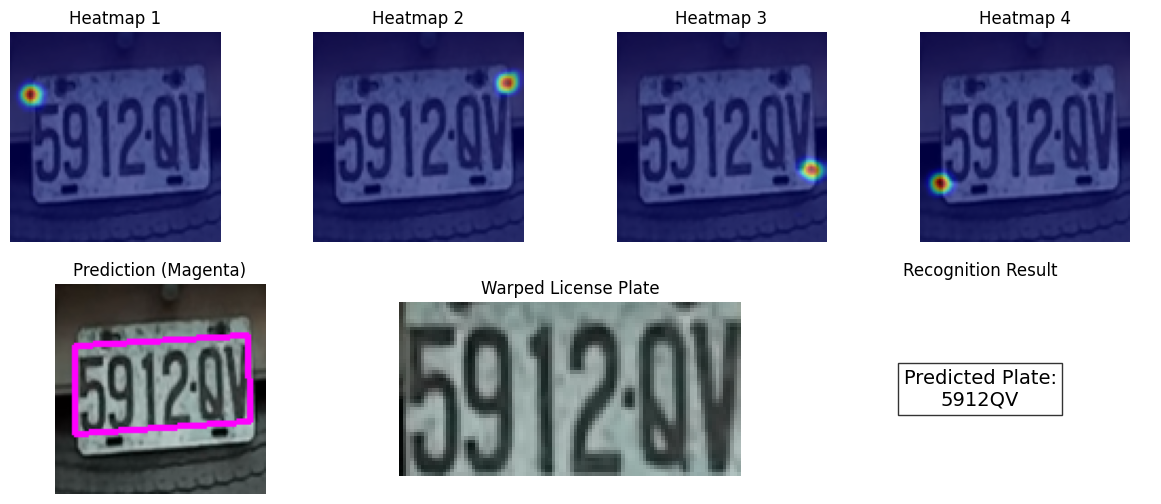

In [7]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === Settings ===
# You can replace this with your own license plate photo
image_file = "/content/test_images/5912QV.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load image and preprocess ===
image = cv2.imread(image_file)
resized_img = cv2.resize(image, (100, 100)).astype(float) / 255.0
input_tensor = torch.from_numpy(resized_img).permute(2, 0, 1).unsqueeze(0).float().to(device)

# === Run CPM model ===
cpm_model.eval()
with torch.no_grad():
    _, heatmap_out = cpm_model(input_tensor)
    heatmap_out = F.interpolate(heatmap_out, size=(100, 100), mode='bilinear', align_corners=False)
heatmaps = heatmap_out.squeeze(0).cpu().numpy()

# === Get predicted points ===
pred_points = [np.unravel_index(np.argmax(hm), hm.shape) for hm in heatmaps]
pred_points = np.array([(x, y) for y, x in pred_points])

# === Sort predicted corners ===
def sort_corners(pts):
    sums = pts.sum(axis=1)
    diffs = np.diff(pts, axis=1).flatten()
    ordered = [pts[np.argmin(sums)], pts[np.argmin(diffs)], pts[np.argmax(sums)], pts[np.argmax(diffs)]]
    ordered.append(ordered[0])
    return np.array(ordered, dtype=np.int32)

pred_ordered = sort_corners(pred_points)

# === Draw prediction box ===
vis_img = (resized_img * 255).astype(np.uint8).copy()
for i in range(4):
    cv2.line(vis_img, tuple(pred_ordered[i]), tuple(pred_ordered[i + 1]), (255, 0, 255), 2)

# === Perspective transform ===
src = pred_ordered[:-1].astype(np.float32)
dst = np.array([[0, 0], [93, 0], [93, 47], [0, 47]], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective((resized_img * 255).astype(np.uint8), M, (94, 48))

# === Run LPR model ===
warped_input = warped.astype('float32')
warped_input = (warped_input - 127.5) * 0.0078125
warped_input = torch.from_numpy(warped_input.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

with torch.no_grad():
    prebs = lpr_model(warped_input).cpu().numpy()[0]

# === Decode predicted labels ===
preb_label = [np.argmax(prebs[:, j]) for j in range(prebs.shape[1])]
no_repeat = []
pre_c = preb_label[0]
if pre_c != len(CHARS) - 1:
    no_repeat.append(pre_c)
for c in preb_label:
    if c != pre_c and c != len(CHARS) - 1:
        no_repeat.append(c)
    pre_c = c
plate_number = ''.join([CHARS[i] for i in no_repeat])

# === Plot everything nicely ===
fig = plt.figure(figsize=(15, 6))

# Heatmaps
for i, hm in enumerate(heatmaps):
    ax = fig.add_subplot(2, len(heatmaps), i + 1)
    ax.imshow(resized_img)
    ax.imshow(hm, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(f"Heatmap {i+1}")

# Prediction box
ax_pred = fig.add_subplot(2, 3, 4)
ax_pred.imshow(vis_img)
ax_pred.axis('off')
ax_pred.set_title("Prediction (Magenta)")

# Warped plate
ax_warped = fig.add_subplot(2, 3, 5)
ax_warped.imshow(warped)
ax_warped.axis('off')
ax_warped.set_title("Warped License Plate")

# Predicted plate number
ax_text = fig.add_subplot(2, 3, 6)
ax_text.axis('off')
ax_text.text(0.5, 0.5, f"Predicted Plate:\n{plate_number}", fontsize=14,
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
ax_text.set_title("Recognition Result")

plt.tight_layout()
plt.show()
